<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-MCD/blob/main/06-Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Naive Bayes</h1>

En esta notebook usaremos el algoritmo Naive Bayes para tareas de clasificación de texto.

Para esto, usaremos el corpus `20newsgroups`.

Algunos aspectos importantes a observar:

* Comparación del desempeño del NaiveBayes como algoritmo de clasificación con otros algoritmos.
* Interpretabilidad del modelo: palabras más representativas por clase.

In [1]:
!pip install -qq wordcloud

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# El corpus y limpieza

Cargamos el corpus. Nos fijaremos en dos categorias: *space* y *baseball*.

In [3]:
train_data = fetch_20newsgroups(subset='train',
                                remove=('headers', 'footers', 'quotes'),
                                categories=['sci.space', 'rec.sport.baseball']
                                )
test_data = fetch_20newsgroups(subset='test',
                                remove=('headers', 'footers', 'quotes'),
                                categories=['sci.space', 'rec.sport.baseball']
                               )

X_train_raw = train_data.data
y_train = train_data.target

X_test_raw = test_data.data
y_test = test_data.target

La clase negativa es *baseball* y la clase positiva es *space*.

In [4]:
class_names_dict = dict(zip([0,1],train_data.target_names))
class_names_dict

{0: 'rec.sport.baseball', 1: 'sci.space'}

In [5]:
import re

X_train_raw = [x.lower() for x in X_train_raw]
X_train_raw = [re.sub(r'\d', ' ', x) for x in X_train_raw]
X_train_raw = [re.sub(f'[^a-z ]','',x) for x in X_train_raw]

X_test_raw = [x.lower() for x in X_test_raw]
X_test_raw = [re.sub(r'\d', ' ', x) for x in X_test_raw]
X_test_raw = [re.sub(f'__',' ',x) for x in X_test_raw]

# Modelo BOW

Obtengamos los conteos con el modelo `BOW`.

In [6]:
cv = CountVectorizer(max_features=2000,stop_words='english')
X_train_bow = cv.fit_transform(X_train_raw)
X_test_bow = cv.transform(X_test_raw)

print(X_train_bow.shape)
print(X_test_bow.shape)

(1190, 2000)
(791, 2000)


In [7]:
cv.get_feature_names_out()

array(['aa', 'aaa', 'ab', ..., 'youve', 'zero', 'zone'], dtype=object)

In [8]:
print(y_train.shape)
print(y_test.shape)

(1190,)
(791,)


# Clasificador Naive Bayes

Instanciamos y entrenamos el clasificador [Naive Bayes Multinomial](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).

In [9]:
nb = MultinomialNB()
nb.fit(X_train_bow, y_train)

MultinomialNB()

Realizamos las predicciones y evaluamos el desempeño del modelo

In [10]:
y_pred = nb.predict(X_test_bow)

nb_acc = accuracy_score(y_test, y_pred)
nb_f1 = f1_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[381  16]
 [ 40 354]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       397
           1       0.96      0.90      0.93       394

    accuracy                           0.93       791
   macro avg       0.93      0.93      0.93       791
weighted avg       0.93      0.93      0.93       791



Accedemos a las probabilidades logaritmicas de cada palabra, en cada clase.

In [11]:
nb.feature_log_prob_.shape

(2, 2000)

In [12]:
#@title Definimos una función que nos muestre las palabras más determinantes en cada clase

def show_top_words(classifier, vectorizer, categories, top_n):
  feature_names = np.asarray(vectorizer.get_feature_names_out())
  for i, category in enumerate(categories):
    prob_sorted = classifier.feature_log_prob_[i, :].argsort()[::-1]
    print(f"{category}:\n\t{' | '.join(feature_names[prob_sorted[:top_n]])}")

Veamos las palabras más determinantes en cada clase, en orden:

**Son las palabras con probabilidad más alta de ocurrir en cada clase**

In [13]:
show_top_words(nb, cv, train_data.target_names, 12)

rec.sport.baseball:
	year | good | think | game | team | dont | like | just | better | games | hit | runs
sci.space:
	space | launch | nasa | like | data | just | lunar | satellite | time | shuttle | orbit | earth


In [14]:
#@title Función para colorear todas las palabras del mismo color

def frequency_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    '''
    Función que regresa el color gris
    '''
    return "hsl(0,0%, 40%)"

Veamos las palabras más frecuentes por clase:

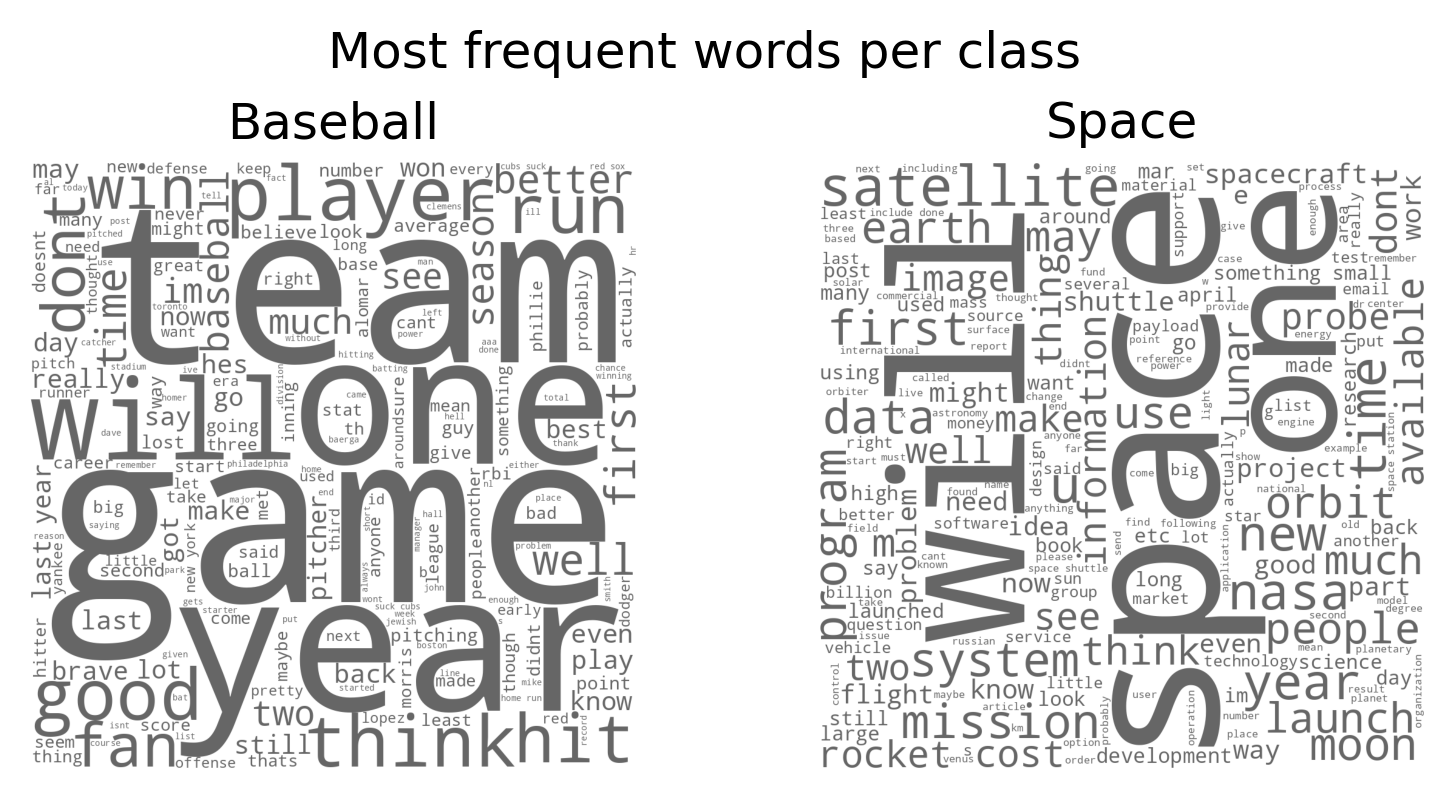

In [15]:
baseball_docs = [x for x, y in zip(X_train_raw, y_train) if y == 0]
space_docs = [x for x, y in zip(X_train_raw, y_train) if y == 1]

fig, axs = plt.subplots(1, 2,figsize=(6,3),dpi=300)
fig.suptitle("Most frequent words per class")
fig.subplots_adjust(hspace=0.5,wspace=0.3)
# Wordcloud de documentos de baseball:
wordcloud = WordCloud(width = 1000, height = 1000,
                    background_color ='white',
                      min_font_size = 10).generate(' '.join(baseball_docs))
axs[0].set_title("Baseball")
axs[0].imshow(wordcloud.recolor(color_func=frequency_color_func))
axs[0].axis("off")
# Wordcloud de documentos del espacio:
wordcloud = WordCloud(width = 1000, height = 1000,
                    background_color ='white',
                    min_font_size = 10).generate(' '.join(space_docs))
axs[1].set_title("Space")
axs[1].imshow(wordcloud.recolor(color_func=frequency_color_func))
axs[1].axis("off")
axs[1].set_title("Space")

fig.show()

Veamos las palabras con las probabilidades más altas por cada clase:

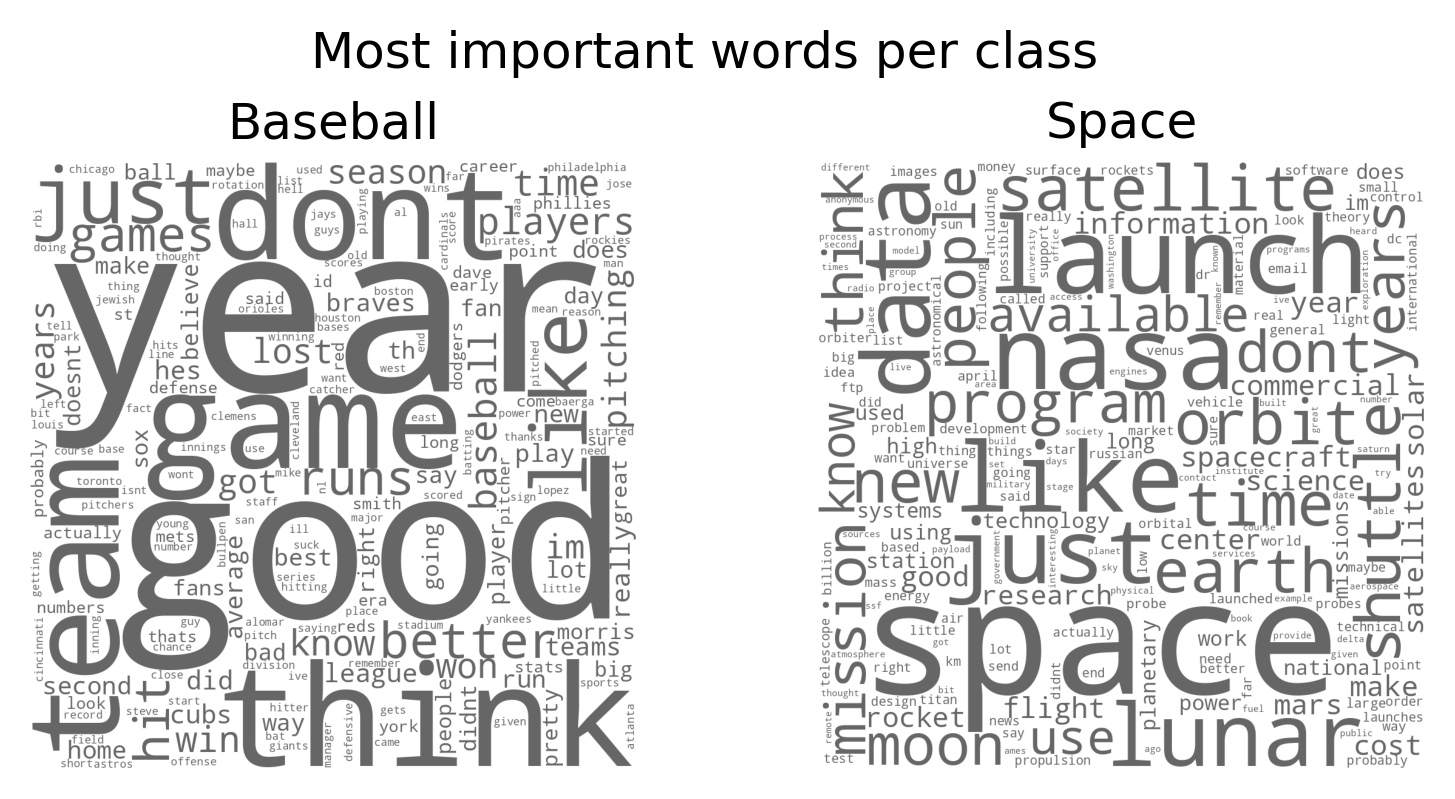

In [16]:
probs = np.transpose(np.exp(nb.feature_log_prob_))

probs_neg = dict(zip(cv.get_feature_names_out(),probs[:,0]))
probs_pos = dict(zip(cv.get_feature_names_out(),probs[:,1]))

fig, axs = plt.subplots(1, 2,figsize=(6,3),dpi=300)
fig.suptitle("Most important words per class")
fig.subplots_adjust(hspace=0.5,wspace=0.3)
# Wordcloud de documentos de baseball:
wordcloud = WordCloud(width = 1000, height = 1000,
                    background_color ='white',
                      min_font_size = 10).generate_from_frequencies(probs_neg)
axs[0].set_title("Baseball")
axs[0].imshow(wordcloud.recolor(color_func=frequency_color_func))
axs[0].axis("off")
# Wordcloud de documentos del espacio:
wordcloud = WordCloud(width = 1000, height = 1000,
                    background_color ='white',
                    min_font_size = 10).generate_from_frequencies(probs_pos)
axs[1].set_title("Space")
axs[1].imshow(wordcloud.recolor(color_func=frequency_color_func))
axs[1].axis("off")
axs[1].set_title("Space")

fig.show()

Probemos con un documento de prueba ajeno:

https://en.wikipedia.org/wiki/Main_Page

In [31]:
new_text = '''
First Horizon Park, formerly known as First Tennessee Park, is a baseball park in downtown Nashville, Tennessee, United States. The home of the Triple-A Nashville Sounds of the International League, it opened on April 17, 2015, and can seat up to 10,000 people. It replaced the Sounds' former home, Herschel Greer Stadium, where the team played from its founding in 1978 through 2014.

The park was built on the site of the former Sulphur Dell, a minor league ballpark in use from 1885 to 1963. It is located between Third and Fifth Avenues on the east and west (home plate, the pitcher's mound, and second base are directly in line with Fourth Avenue to the stadium's north and south) and between Junior Gilliam Way and Harrison Street on the north and south. The Nashville skyline can be seen from the stadium to the south.

The design of the park incorporates elements of Nashville's baseball and musical heritage and the use of imagery inspired by Sulphur Dell, the city's former baseball players and teams, and country music. Its most distinctive feature is its guitar-shaped scoreboard—a successor to the original guitar scoreboard at Greer Stadium. The ballpark's wide concourse wraps entirely around the stadium and provides views of the field from every location.

Though primarily a venue for the Nashville Sounds, collegiate and high school baseball teams based in the area, such as the Vanderbilt Commodores and Belmont Bruins, have played some games at the ballpark. Nashville SC, a soccer team of the United Soccer League Championship, played its home matches at the facility from 2018 to 2019. It has also hosted other events, including celebrity softball games and various food and drink festivals.
'''

cv_new_text = cv.transform([new_text])
preds = nb.predict(cv_new_text)
print(class_names_dict[preds[0]])

rec.sport.baseball


# Naive Bayes + Tf-Idf

In [18]:
tfidf_vectorizer = CountVectorizer(max_features=2000,stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)

tfidf_nb = MultinomialNB()
tfidf_nb.fit(X_train_tfidf, y_train)
y_pred = tfidf_nb.predict(X_test_tfidf)

tfidf_nb_acc = accuracy_score(y_test, y_pred)
tfidf_nb_f1 = f1_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[381  16]
 [ 40 354]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       397
           1       0.96      0.90      0.93       394

    accuracy                           0.93       791
   macro avg       0.93      0.93      0.93       791
weighted avg       0.93      0.93      0.93       791



# Otros clasificadores

## Logistic Regression

Veamos un clasificador *baseline* y comparemos el rendimiento

In [19]:
from functools import lru_cache
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_bow, y_train)
y_pred = lr.predict(X_test_bow)

lru_acc = accuracy_score(y_test, y_pred)
lru_f1 = f1_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[366  31]
 [ 50 344]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       397
           1       0.92      0.87      0.89       394

    accuracy                           0.90       791
   macro avg       0.90      0.90      0.90       791
weighted avg       0.90      0.90      0.90       791



Veamos las palabras más determinantes para predecir la clase positiva (space). Comparemos con el Naive Bayes.

In [20]:
fts_importance = lr.coef_.reshape(-1,)

sorted(zip(fts_importance, cv.get_feature_names_out()),key=lambda x: x[0], reverse=True)[:10]

[(np.float64(2.0553096195094525), 'space'),
 (np.float64(1.0665520635954877), 'orbit'),
 (np.float64(1.0449236921003184), 'solar'),
 (np.float64(0.8921034255752172), 'stuff'),
 (np.float64(0.8902236904333037), 'cost'),
 (np.float64(0.8627787187517626), 'launch'),
 (np.float64(0.8514419192466094), 'nasa'),
 (np.float64(0.812264597176097), 'moon'),
 (np.float64(0.7944820979537476), 'joke'),
 (np.float64(0.78856532582169), 'sounds')]

In [21]:
sorted(zip(fts_importance, cv.get_feature_names_out()),key=lambda x: x[0])[:10]

[(np.float64(-1.4272530667334489), 'baseball'),
 (np.float64(-1.183004979803623), 'stadium'),
 (np.float64(-1.148758422002523), 'players'),
 (np.float64(-1.1068070985176937), 'jewish'),
 (np.float64(-1.0400766989442185), 'game'),
 (np.float64(-1.003459210095416), 'team'),
 (np.float64(-0.9754674733918413), 'games'),
 (np.float64(-0.9625448711620435), 'play'),
 (np.float64(-0.9333380808210616), 'teams'),
 (np.float64(-0.9241264257669295), 'hit')]

## Support Vector Machine

In [22]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train_bow, y_train)
y_pred = svm.predict(X_test_bow)

svm_acc = accuracy_score(y_test, y_pred)
svm_f1 = f1_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[376  21]
 [ 90 304]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       397
           1       0.94      0.77      0.85       394

    accuracy                           0.86       791
   macro avg       0.87      0.86      0.86       791
weighted avg       0.87      0.86      0.86       791



## Con embeddings generados por un modelo de lenguaje

Entrenemos un modelo usando embeddings de un modelo basado en transformadores, [RoBERTa](https://huggingface.co/docs/transformers/model_doc/roberta).

In [23]:
!gdown 1qvEuXjb65m6Vh5gn6-XScqtVQz9b1Gme
!gdown 14grKYRMZs96xd-tzEvDpEFc4FBO6Vm2H

Downloading...
From: https://drive.google.com/uc?id=1qvEuXjb65m6Vh5gn6-XScqtVQz9b1Gme
To: /content/imdb-test-space_baseball-roberta.npy
100% 2.43M/2.43M [00:00<00:00, 224MB/s]
Downloading...
From: https://drive.google.com/uc?id=14grKYRMZs96xd-tzEvDpEFc4FBO6Vm2H
To: /content/imdb-train-space_baseball-roberta.npy
100% 3.66M/3.66M [00:00<00:00, 209MB/s]


In [24]:
train_embeddings = np.load("imdb-train-space_baseball-roberta.npy")
test_embeddings = np.load("imdb-test-space_baseball-roberta.npy")

print(train_embeddings.shape)
print(test_embeddings.shape)

(1190, 768)
(791, 768)


In [25]:
from sklearn.svm import SVC

svm = SVC(C=2.5)
svm.fit(train_embeddings, y_train)
y_pred = svm.predict(test_embeddings)

svm_emb_acc = accuracy_score(y_test, y_pred)
svm_emb_f1 = f1_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[383  14]
 [ 54 340]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       397
           1       0.96      0.86      0.91       394

    accuracy                           0.91       791
   macro avg       0.92      0.91      0.91       791
weighted avg       0.92      0.91      0.91       791



## Comparación de los desempeños

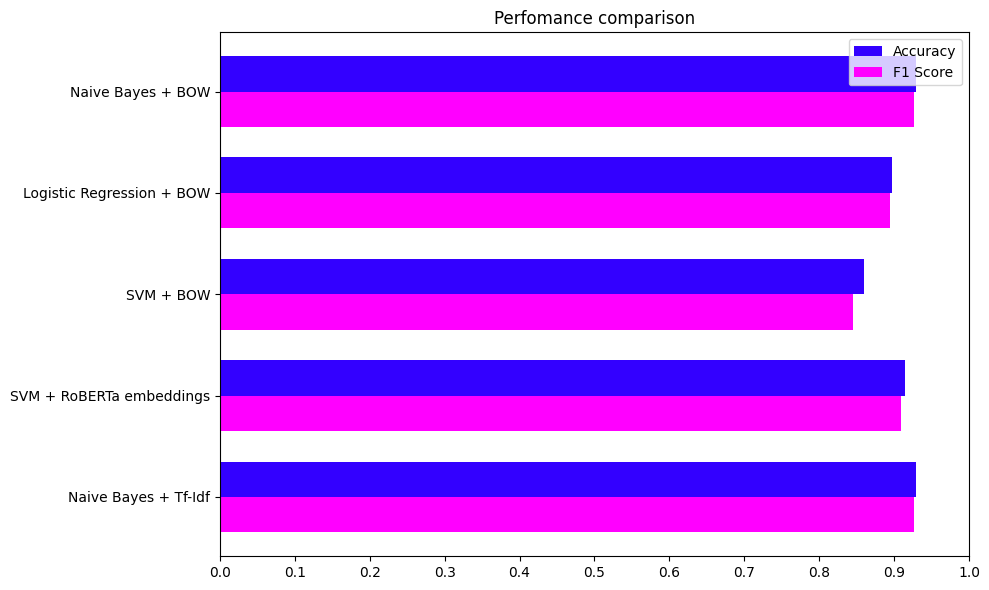

In [26]:
names = ['Naive Bayes + BOW', 'Logistic Regression + BOW', 'SVM + BOW',
         'SVM + RoBERTa embeddings', 'Naive Bayes + Tf-Idf']
accs = [nb_acc, lru_acc, svm_acc, svm_emb_acc, tfidf_nb_acc]
f1s = [nb_f1, lru_f1, svm_f1, svm_emb_f1, tfidf_nb_f1]

y = np.arange(len(names))
height = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(y - height/2, accs, height, label='Accuracy', color='#3300FF')
ax.barh(y + height/2, f1s, height, label='F1 Score', color='#FF00FF')

ax.set_yticks(y)
ax.set_yticklabels(names)
ax.invert_yaxis()  # Labels read top-to-bottom
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_title('Perfomance comparison')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

## Con $n$-gramas

In [27]:
cv_grams = CountVectorizer(max_features=2000,stop_words='english', ngram_range=(2,3))
X_train_tfidf_grams = cv_grams.fit_transform(X_train_raw)
X_test_tfidf_grams = cv_grams.transform(X_test_raw)

print(X_train_tfidf_grams.shape)
print(X_test_tfidf_grams.shape)

(1190, 2000)
(791, 2000)


In [28]:
vocab = []
for x in cv_grams.get_feature_names_out():
    if len(x.split(" "))>1:
        x = x.replace(" ","-")
        vocab.append(x)
    else:
        vocab.append(x)
print(vocab[:10])

['abort-order', 'acceptable-range', 'accepted-number', 'accepted-number-expiration', 'accessed-hoursday', 'accomplished-similar', 'accomplished-similar-mission', 'accurate-global', 'accurate-global-observations', 'active-duty']


In [29]:
nb_grams = MultinomialNB()
nb_grams.fit(X_train_tfidf_grams, y_train)
y_pred = nb_grams.predict(X_test_tfidf_grams)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[385  12]
 [189 205]]
              precision    recall  f1-score   support

           0       0.67      0.97      0.79       397
           1       0.94      0.52      0.67       394

    accuracy                           0.75       791
   macro avg       0.81      0.75      0.73       791
weighted avg       0.81      0.75      0.73       791



In [30]:
show_top_words(nb_grams, cv_grams, train_data.target_names, 10)

rec.sport.baseball:
	new york | red sox | suck cubs | cubs suck | cubs suck cubs | dont know | suck cubs suck | st louis | dont think | los angeles
sci.space:
	space shuttle | space station | anonymous ftp | washington dc | commercial space | remote sensing | physical universe | nasa ames | national space | available anonymous


🟥 Ejercicios Tarea

1. La implementación de scikit-learn de Naive Bayes tiene un parámetro para controlar el suavizado. Haz una busqueda de parámetros para obtener el *mejor* clasificador Naive Bayes que te sea posible.
2. Usando cualquier clasificador clásico de Machine Learning de tu preferencia, busca supera el rendimiento del clasificador Naive Bayes. Escoge uno, ya sea que mejore o el que más se acerque al rendimiento del Naive Bayes.
3. Repite el ejercicio 2 usando un clasificador basado en una red neuronal. Reporta el mejor rendimiento.

En los tres casos, usa el F1 score. Compara los 3 resultados en un gráfico similar al que hicimos en esta notebook.

4. Repite los experimentos 1-3 con un nuevo corpus. Este corpus son 50K reviews de IMDB, es una tarea de análisis de sentimientos. El corpus lo puedes bajar usando la instrucción:

        !gdown 18kGdlhOiQNS61wUK7uPbdquKL3XJrgzf

5. Con la experiencia ganada con esta notebook y estos experimentos. Responde lo siguiente ¿qué opinas sobre el papel del algoritmo Naive Bayes en la clasificación de texto? ¿qué ventajas y desventajas observas?